In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
transforms_from_weights = weights.transforms()

print(transforms_from_weights)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(232),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [1]:
from zipfile import ZipFile
with ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [2]:
classes = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

### Подготовка данных
Из оригинального датасета объединили тестовую выборку с валидационной и добавили из тренировочной выборки несколько файлов в валидационную

In [3]:
import os
import shutil
import random

def move_random_files(source_dir, target_dir, num_files=40, mode='rand'):
    all_files = [f for f in os.listdir(source_dir)
                 if os.path.isfile(os.path.join(source_dir, f))]

    selected_files = random.sample(all_files, num_files) if mode == 'rand' else all_files

    for filename in selected_files:
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        shutil.move(source_path, target_path)

for clas in classes:
  test_folder = f"/content/dataset/Fruits/test/{clas}"
  valid_folder = f"/content/dataset/Fruits/valid/{clas}"
  train_folder = f"/content/dataset/Fruits/train/{clas}"

  move_random_files(train_folder, valid_folder, 40, 'rand')
  move_random_files(test_folder, valid_folder, 40, 'all')

In [10]:
data_dir = '/content/dataset/Fruits'
image_datasets = {
    'train': datasets.ImageFolder(f'{data_dir}/train', data_transforms['train']),
    'val': datasets.ImageFolder(f'{data_dir}/valid', data_transforms['val'])
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True if x == 'train' else False)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [11]:
dataset_sizes

{'train': 9500, 'val': 500}

In [12]:
class_names

['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

In [13]:
num_classes

5

### Обучение модели
Используем модель efficientnet b0 и дообучаем на своих данных

In [14]:
model = timm.create_model('efficientnet_b0', pretrained=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
from pathlib import Path
save_dir = Path(f'results_models')
save_dir.mkdir(exist_ok=True)

In [17]:
num_epochs = 30

In [18]:
history = {
    'train': {'loss': [], 'acc': []},
    'val': {'loss': [], 'acc': []}
}

In [21]:
import torch
from pathlib import Path

val_loss_increase_count = 0
val_acc_decrease_count = 0
best_val_loss = float('inf')
best_val_acc = 0.0
best_model_version = 0
last_best_state = None
last_best_epoch = -1

save_dir = Path('./models')
save_dir.mkdir(parents=True, exist_ok=True)

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            if phase == 'train':
                optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        history[phase]['loss'].append(epoch_loss)
        history[phase]['acc'].append(epoch_acc.item())

        if phase == 'val':
            current_val_loss = epoch_loss
            current_val_acc = epoch_acc.item()

            metrics_improved = False

            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                metrics_improved = True

            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                metrics_improved = True

            if metrics_improved:
                last_best_state = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict().copy(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': current_val_acc,
                    'val_loss': current_val_loss,
                    'best_val_loss': best_val_loss,
                    'best_val_acc': best_val_acc,
                }
                last_best_epoch = epoch

                val_loss_increase_count = 0
                val_acc_decrease_count = 0

                print(f'Metrics improved at epoch {epoch}: Loss={current_val_loss:.4f}, Acc={current_val_acc:.4f}')
            else:
                if current_val_loss > best_val_loss:
                    val_loss_increase_count += 1
                    print(f'Loss increased: {best_val_loss:.4f} → {current_val_loss:.4f} '
                          f'(count: {val_loss_increase_count}/3)')
                else:
                    val_loss_increase_count = 0

                if current_val_acc < best_val_acc:
                    val_acc_decrease_count += 1
                    print(f'Accuracy decreased: {best_val_acc:.4f} → {current_val_acc:.4f} '
                          f'(count: {val_acc_decrease_count}/3)')
                else:
                    val_acc_decrease_count = 0

            if (val_loss_increase_count >= 3 or val_acc_decrease_count >= 3) and last_best_state is not None:
                best_model_version += 1
                model_filename = save_dir / f'best_model_v{best_model_version}.pth'

                torch.save(last_best_state, model_filename)

                print(f'Saved last best version v{best_model_version} from epoch {last_best_epoch} '
                      f'(before degradation started)')
                print(f'  Loss: {last_best_state["val_loss"]:.4f}, '
                      f'Acc: {last_best_state["val_acc"]:.4f}')

                val_loss_increase_count = 0
                val_acc_decrease_count = 0

                best_val_loss = min(best_val_loss, current_val_loss)
                best_val_acc = max(best_val_acc, current_val_acc)

        print(f'{phase} Epoch {epoch}/{num_epochs-1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

torch.save(model.state_dict(), save_dir / 'fruit_classifier_efficientnet_final.pth')

train Epoch 0/29 Loss: 0.4021 Acc: 0.8593
Metrics improved at epoch 0: Loss=0.2451, Acc=0.9100
val Epoch 0/29 Loss: 0.2451 Acc: 0.9100
train Epoch 1/29 Loss: 0.3715 Acc: 0.8689
Loss increased: 0.2451 → 0.2602 (count: 1/3)
Accuracy decreased: 0.9100 → 0.9040 (count: 1/3)
val Epoch 1/29 Loss: 0.2602 Acc: 0.9040
train Epoch 2/29 Loss: 0.3675 Acc: 0.8714
Metrics improved at epoch 2: Loss=0.2095, Acc=0.9140
val Epoch 2/29 Loss: 0.2095 Acc: 0.9140
train Epoch 3/29 Loss: 0.3513 Acc: 0.8788
Loss increased: 0.2095 → 0.2691 (count: 1/3)
Accuracy decreased: 0.9140 → 0.9080 (count: 1/3)
val Epoch 3/29 Loss: 0.2691 Acc: 0.9080
train Epoch 4/29 Loss: 0.3388 Acc: 0.8792
Metrics improved at epoch 4: Loss=0.1842, Acc=0.9400
val Epoch 4/29 Loss: 0.1842 Acc: 0.9400
train Epoch 5/29 Loss: 0.3051 Acc: 0.8903
Loss increased: 0.1842 → 0.2159 (count: 1/3)
Accuracy decreased: 0.9400 → 0.9240 (count: 1/3)
val Epoch 5/29 Loss: 0.2159 Acc: 0.9240
train Epoch 6/29 Loss: 0.3126 Acc: 0.8921
Loss increased: 0.1842 → 

In [22]:
import pandas as pd
df = pd.DataFrame(history)
df.to_csv('metrics.csv')

### Результаты обучения

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history, save_dir=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    axes[0].plot(history['train']['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val']['loss'], label='Val Loss', linewidth=2)
    axes[0].set_title('Loss', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train']['acc'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history['val']['acc'], label='Val Accuracy', linewidth=2)
    axes[1].set_title('Accuracy', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_dir:
        plt.savefig(save_dir / 'training_plots.png', dpi=300, bbox_inches='tight')
        plt.savefig(save_dir / 'training_plots.pdf', bbox_inches='tight')

    plt.show()

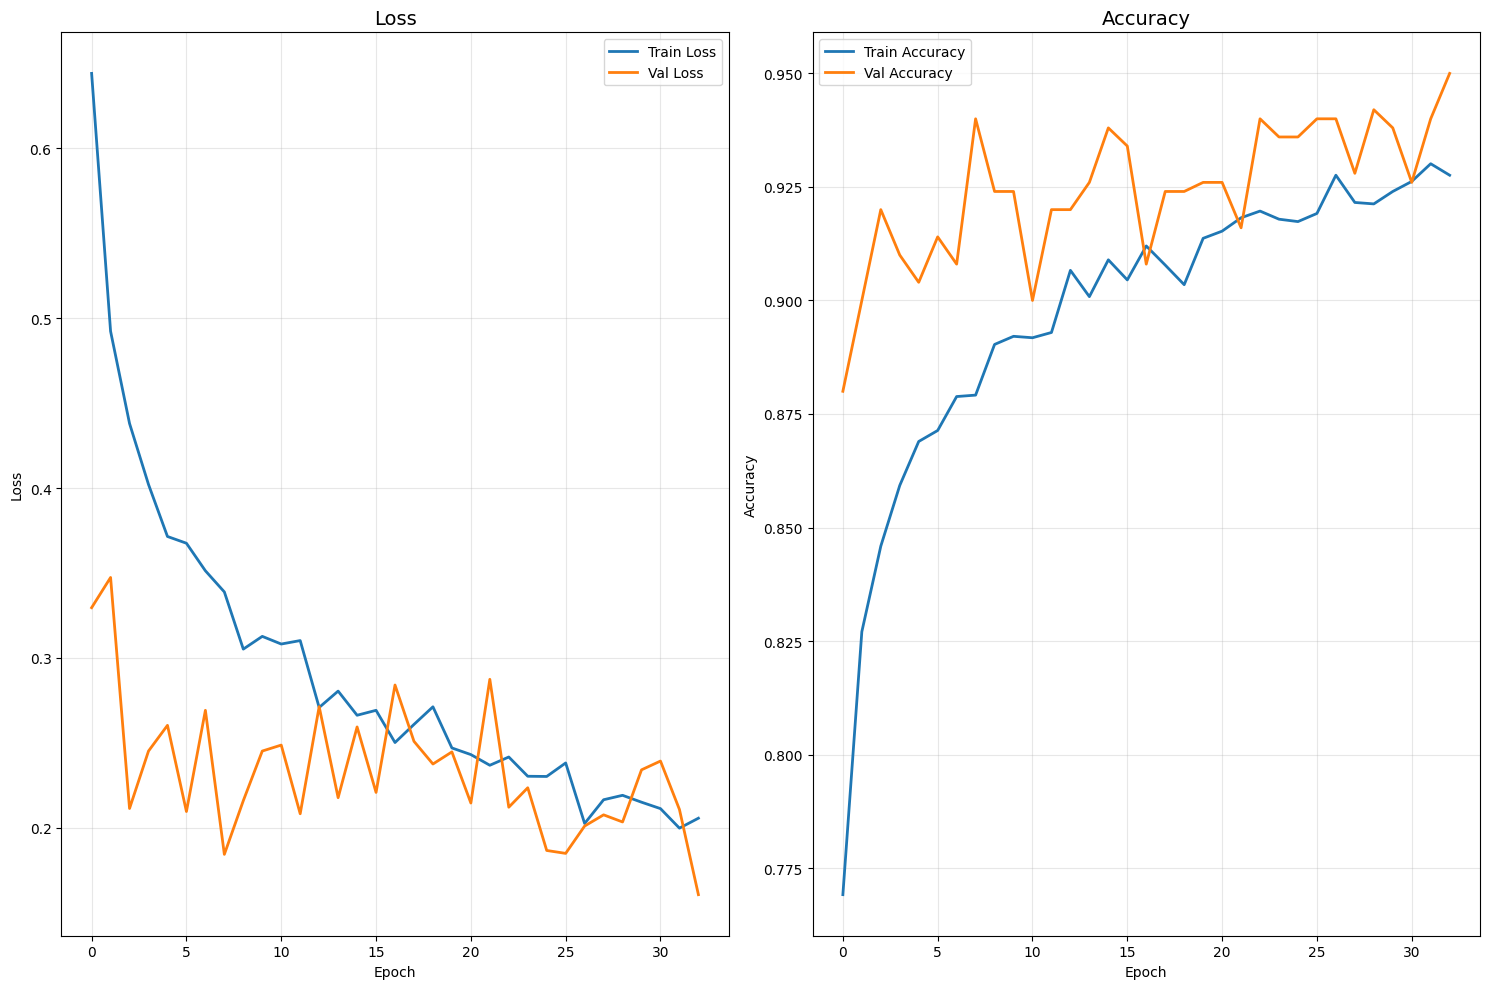

In [33]:
plot_training_history(history)

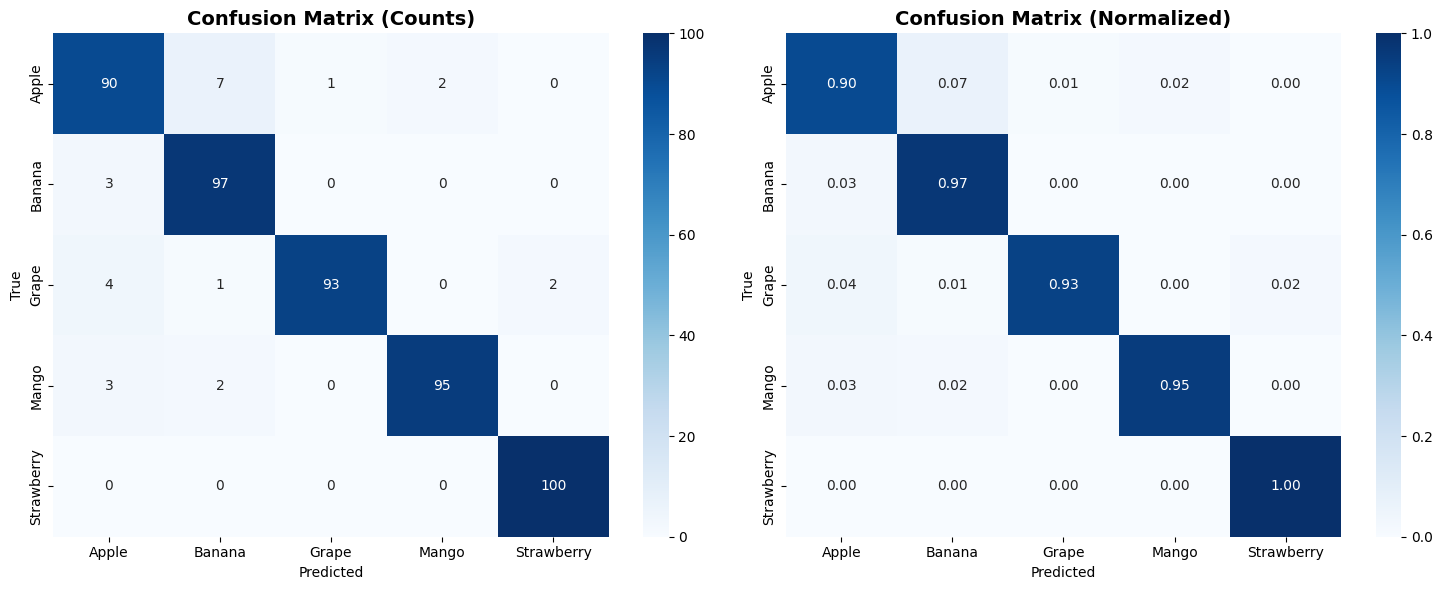

In [35]:
def create_confusion_matrix(model, dataloader, class_names, device='cuda'):
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

create_confusion_matrix(model, dataloaders['val'], class_names)

In [12]:
# model = timm.create_model('efficientnet_b0', pretrained=True)

# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
# )
# state_dict = torch.load('/content/fruit_classifier_efficientnet.pth')
# model.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
with ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

### Тестирование модели на собранном датасете
по 10 изображений каждого класса, взятых из интернета

In [37]:
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import seaborn as sns

def test_model_on_test_set(model, test_dir, img_size=224, batch_size=32):
    model.eval()

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )

    class_names = test_dataset.classes

    all_labels = []
    all_predictions = []
    all_probs = []
    all_image_paths = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    all_image_paths = [test_dataset.samples[i][0] for i in range(len(test_dataset))]

    return all_labels, all_predictions, all_probs, all_image_paths, class_names

In [38]:
labels, preds, probs, pths, class_names = test_model_on_test_set(model, '/content/test/test')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


In [39]:
overall_accuracy = np.mean(labels == preds)
print(f"Total test samples: {len(labels)}")
print(f"Overall accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

Total test samples: 50
Overall accuracy: 0.9000 (90.00%)


In [40]:
class_accuracies = {}
for class_idx, class_name in enumerate(class_names):
    class_mask = labels == class_idx
    if np.sum(class_mask) > 0:
        class_acc = np.mean(preds[class_mask] == class_idx)
        class_accuracies[class_name] = class_acc
        print(f"{class_name:20s}: {class_acc:.4f} ({class_acc*100:.2f}%) - {np.sum(class_mask)} samples")

Apple               : 1.0000 (100.00%) - 10 samples
Banana              : 1.0000 (100.00%) - 10 samples
Grape               : 0.7000 (70.00%) - 10 samples
Mango               : 0.9000 (90.00%) - 10 samples
Strawberry          : 0.9000 (90.00%) - 10 samples


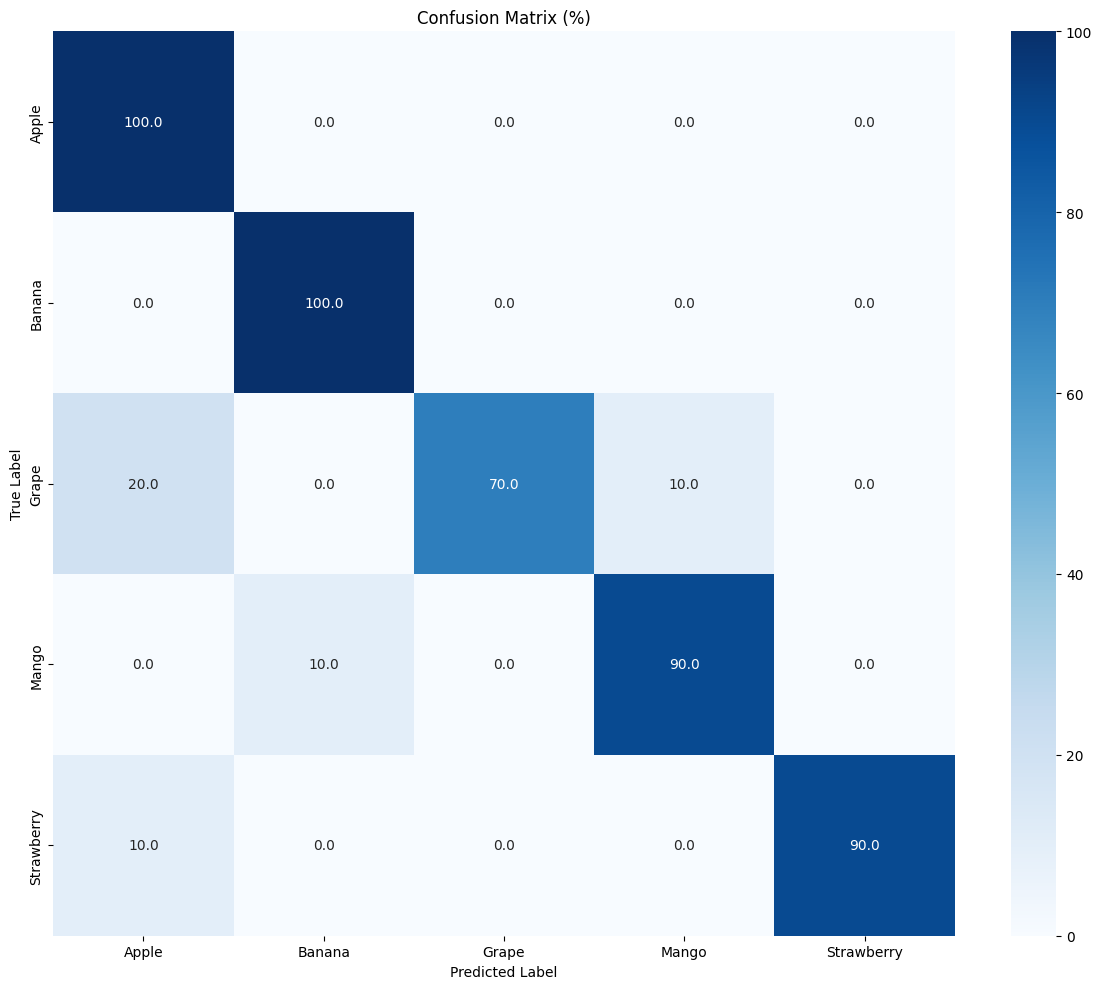

In [41]:
cm = confusion_matrix(labels, preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [43]:
report = classification_report(labels, preds, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

       Apple     0.7692    1.0000    0.8696        10
      Banana     0.9091    1.0000    0.9524        10
       Grape     1.0000    0.7000    0.8235        10
       Mango     0.9000    0.9000    0.9000        10
  Strawberry     1.0000    0.9000    0.9474        10

    accuracy                         0.9000        50
   macro avg     0.9157    0.9000    0.8986        50
weighted avg     0.9157    0.9000    0.8986        50



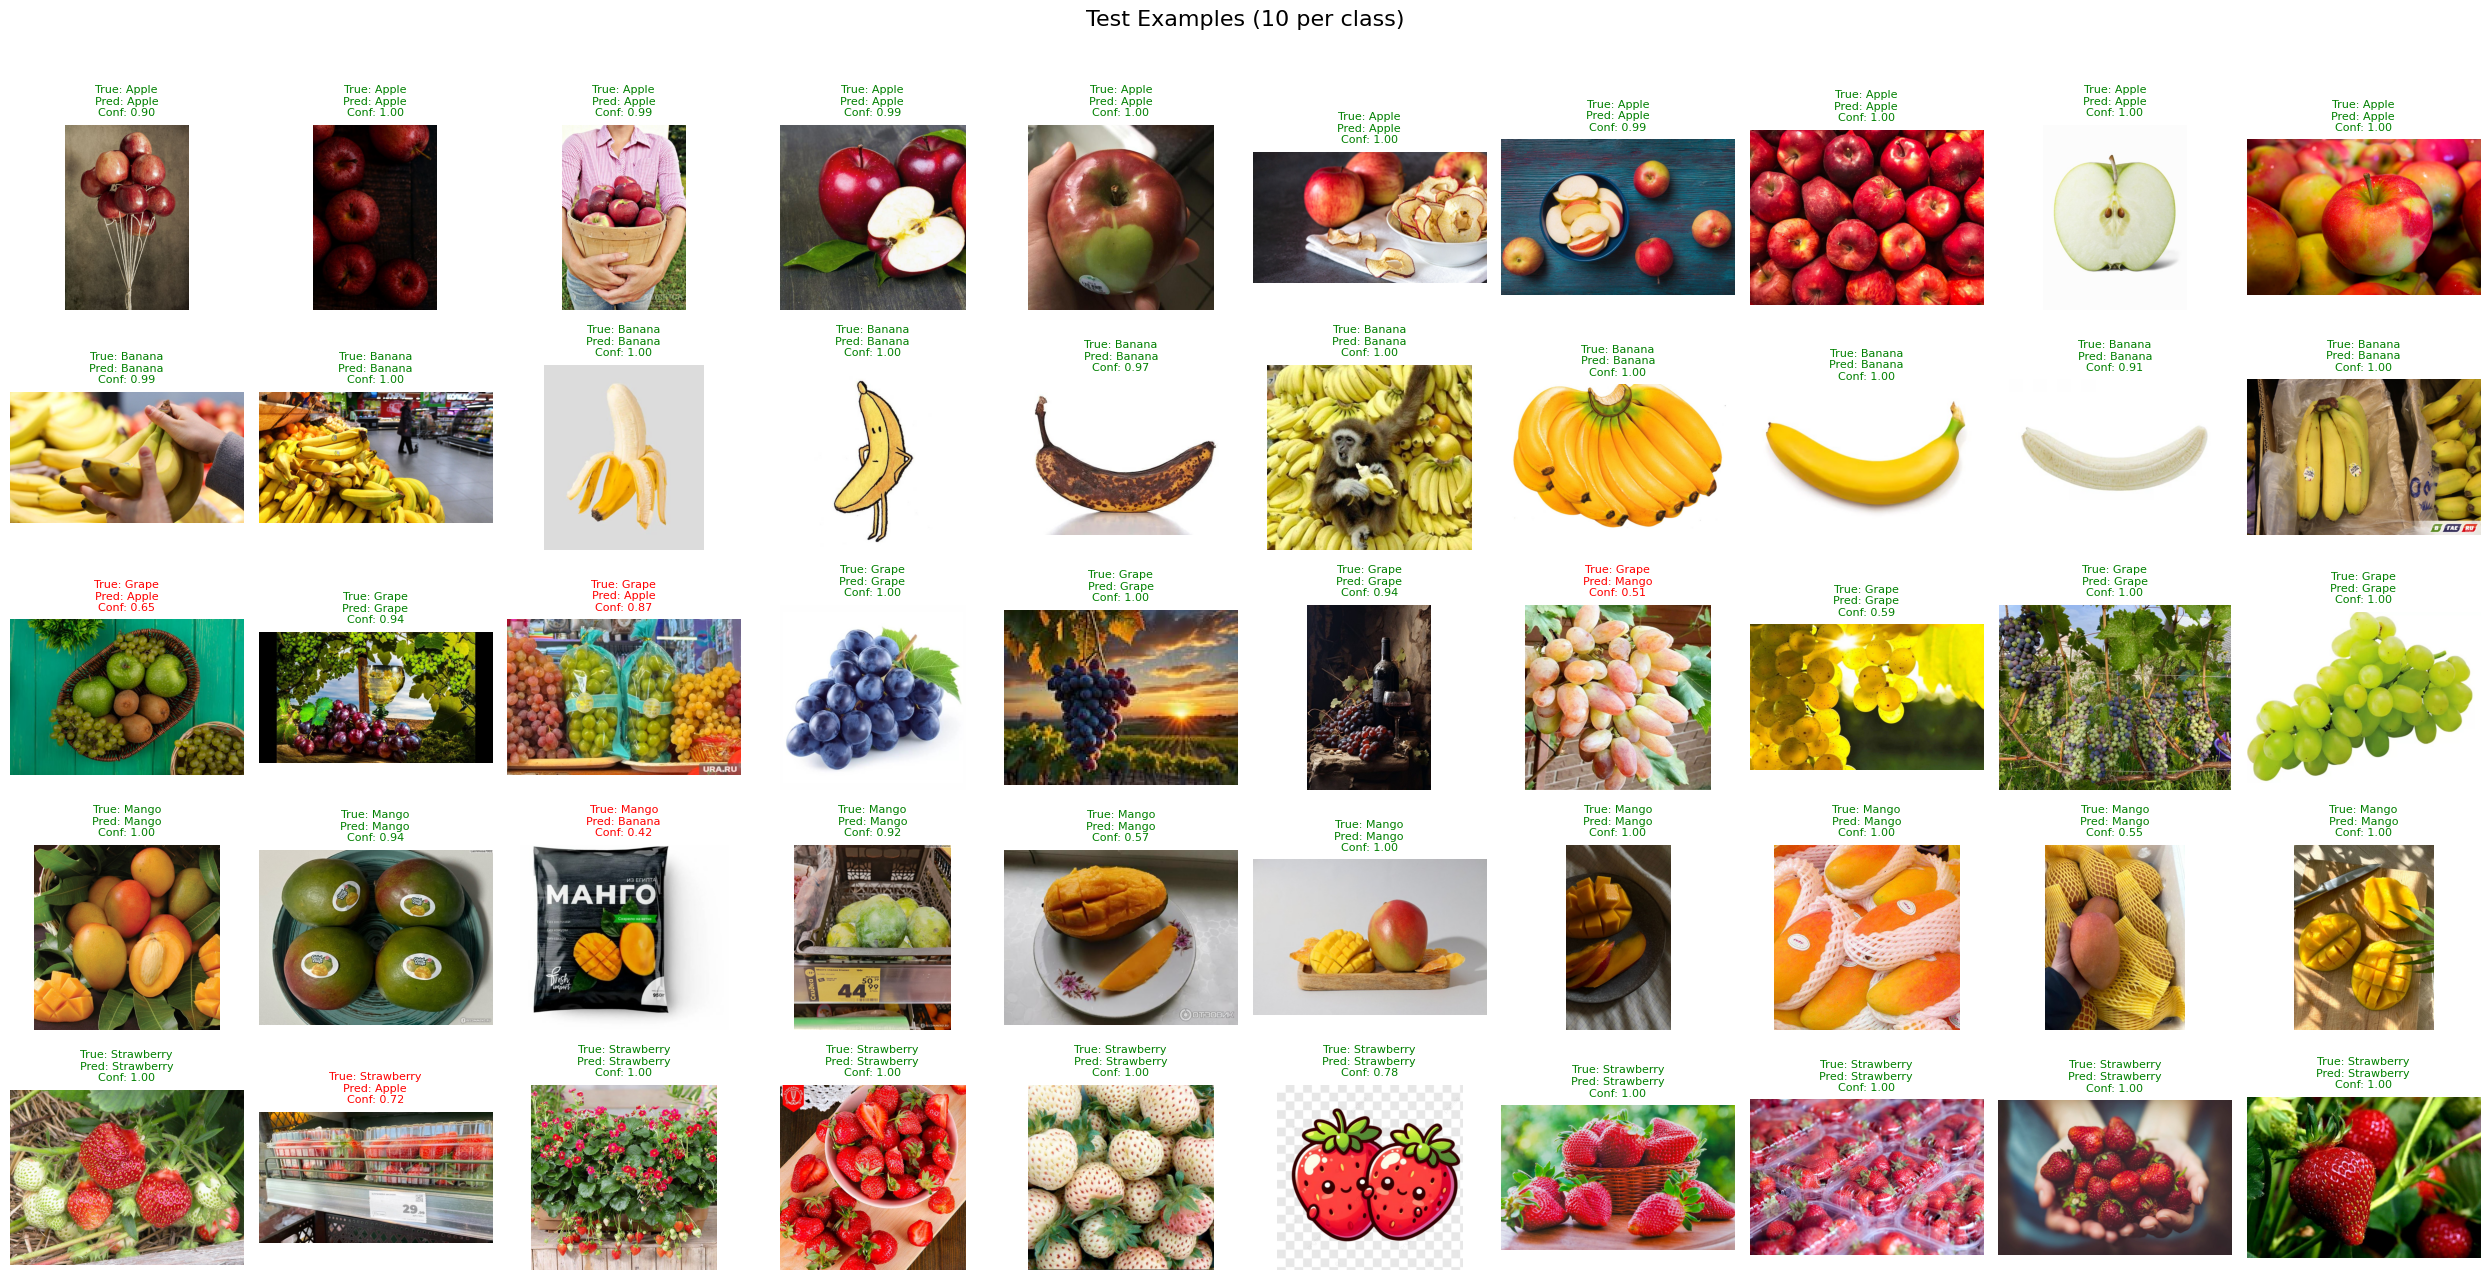

In [47]:
n_classes = len(class_names)
num_samples = 10
fig, axes = plt.subplots(n_classes, num_samples, figsize=(num_samples*2.5, n_classes*2.5))

for class_idx, class_name in enumerate(class_names):
    class_indices = np.where(labels == class_idx)[0]

    sample_indices = np.random.choice(class_indices, num_samples, replace=False)

    for sample_idx, img_idx in enumerate(sample_indices[:num_samples]):
        ax = axes[class_idx, sample_idx]

        img_path = pths[img_idx]
        img = Image.open(img_path).convert('RGB')

        ax.imshow(img)

        true_label = class_names[labels[img_idx]]
        pred_label = class_names[preds[img_idx]]
        confidence = probs[img_idx, preds[img_idx]]

        color = 'green' if true_label == pred_label else 'red'

        ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
                    fontsize=8, color=color)
        ax.axis('off')

plt.suptitle(f'Test Examples ({num_samples} per class)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()